In [1]:
%matplotlib notebook

import rospy
import actionlib
import jupyros
from actionlib import GoalStatus
from assignment_2_2024.msg import PlanningGoal, PlanningAction
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from collections import deque

In [2]:
# Global variables
robot_x = 0.0
robot_y = 0.0
min_distance = float('inf')
targets_reached = 0
targets_cancelled = 0

# Create deques for historical data
robot_positions_x = deque(maxlen=100)
robot_positions_y = deque(maxlen=100)
target_positions_x = deque(maxlen=10)
target_positions_y = deque(maxlen=10)

<IPython.core.display.Javascript object>


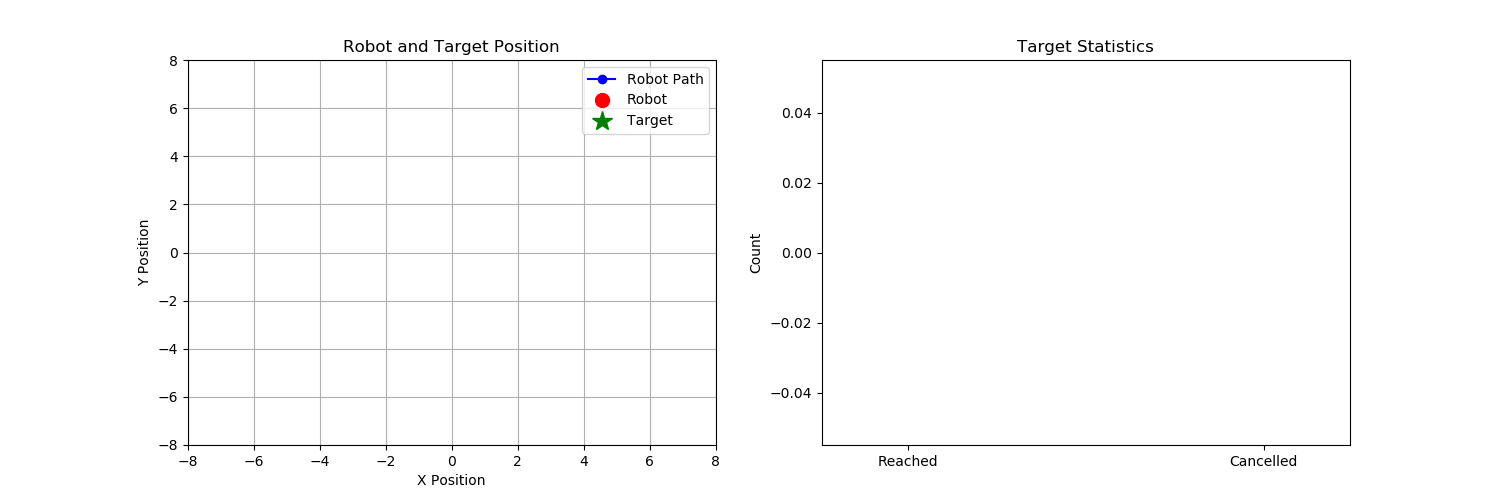

In [3]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Setup Robot Position Plot
line_robot, = ax1.plot([], [], 'bo-', label='Robot Path')
point_robot, = ax1.plot([], [], 'ro', markersize=10, label='Robot')
point_target, = ax1.plot([], [], 'g*', markersize=15, label='Target')

ax1.set_xlim(-8, 8)
ax1.set_ylim(-8, 8)
ax1.grid(True)
ax1.set_title('Robot and Target Position')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.legend()

# Setup Target Statistics Plot
bar_width = 0.35
x = np.arange(2)
bars = ax2.bar(x, [0, 0], bar_width, label=['Reached', 'Cancelled'])
ax2.set_xticks(x)
ax2.set_xticklabels(['Reached', 'Cancelled'])
ax2.set_title('Target Statistics')
ax2.set_ylabel('Count')

# Setup Distance Widget
distance_widget = widgets.FloatProgress(
    value=0,
    min=0,
    max=10.0,
    description='Obstacle Distance:',
    bar_style='info',
    orientation='horizontal',
    layout=widgets.Layout(width='50%', height='25px')
)

distance_label = widgets.Label(value='No data')
distance_container = widgets.VBox([
    widgets.Label(value='Distance from Closest Obstacle:'),
    widgets.HBox([distance_widget, distance_label])
])

# Setup Control Widgets
msg_output = widgets.Textarea(
    value="",
    description="Logs",
    layout=widgets.Layout(width='100%', height='200px')
)
x_goal = widgets.FloatText(description='X Target:')
y_goal = widgets.FloatText(description='Y Target:')
set_goal_btn = widgets.Button(description="Set Goal", button_style='success')
cancel_goal_btn = widgets.Button(description="Cancel Goal", button_style='danger')


In [4]:
# Callback functions
def odometry_callback(data):
    global robot_x, robot_y
    robot_x = data.pose.pose.position.x
    robot_y = data.pose.pose.position.y
    robot_positions_x.append(robot_x)
    robot_positions_y.append(robot_y)

def laser_callback(data):
    global min_distance
    ranges = np.array(data.ranges)
    valid_ranges = ranges[np.isfinite(ranges) & (ranges > 0)]
    
    if len(valid_ranges) > 0:
        min_distance = float(np.min(valid_ranges))
        distance_widget.value = min_distance if min_distance <= 10.0 else 10.0
        distance_label.value = f'{min_distance:.2f} m'
        
        if min_distance < 1.0:
            distance_widget.bar_style = 'danger'
        elif min_distance < 2.0:
            distance_widget.bar_style = 'warning'
        else:
            distance_widget.bar_style = 'success'
    else:
        min_distance = float('inf')
        distance_widget.value = 0
        distance_label.value = 'No obstacles detected'
        distance_widget.bar_style = 'info'


In [5]:
def feedback_handler(feedback):
    global targets_reached
    if feedback.stat == "Target reached!":
        targets_reached += 1
        msg_output.value += f"\nTarget reached at position {feedback.actual_pose}"


In [6]:
def animate(frame):
    line_robot.set_data(list(robot_positions_x), list(robot_positions_y))
    point_robot.set_data([robot_x], [robot_y])
    
    if target_positions_x and target_positions_y:
        point_target.set_data([target_positions_x[-1]], [target_positions_y[-1]])
    
    bars[0].set_height(targets_reached)
    bars[1].set_height(targets_cancelled)
    ax2.relim()
    ax2.autoscale_view()
    
    return line_robot, point_robot, point_target, bars[0], bars[1]

In [7]:
def dispatch_goal(b):
    x_target = x_goal.value
    y_target = y_goal.value
    target_positions_x.append(x_target)
    target_positions_y.append(y_target)
    
    goal_msg = PlanningGoal()
    goal_msg.target_pose.pose.position.x = x_target
    goal_msg.target_pose.pose.position.y = y_target
    
    action_client.send_goal(goal_msg, feedback_cb=feedback_handler)
    msg_output.value += f"\nDispatched goal: X={x_target}, Y={y_target}"

def cancel_goal(b):
    global targets_cancelled
    if action_client.get_state() in [GoalStatus.ACTIVE, GoalStatus.PENDING]:
        action_client.cancel_goal()
        targets_cancelled += 1
        msg_output.value += "\nGoal canceled!"

Textarea(value='', description='Logs', layout=Layout(height='200px', width='100%'))

<IPython.core.display.Javascript object>


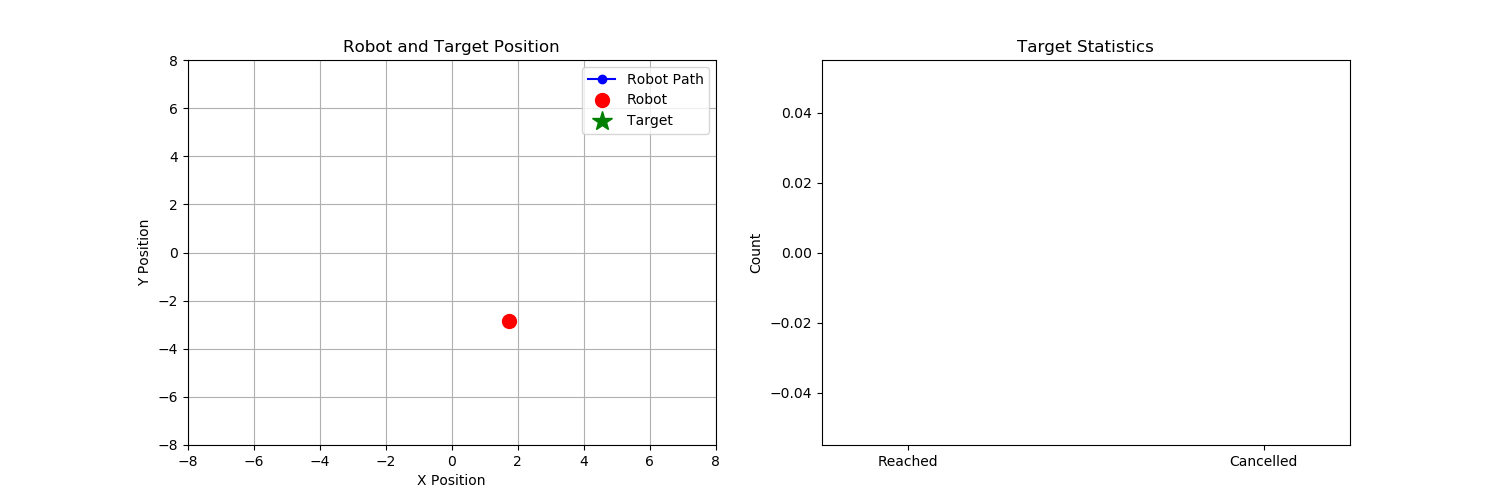

In [8]:
# Setup button callbacks
set_goal_btn.on_click(dispatch_goal)
cancel_goal_btn.on_click(cancel_goal)

# Display widgets
display(widgets.HBox([x_goal, y_goal, set_goal_btn, cancel_goal_btn]))
display(distance_container)
display(msg_output)
plt.close(fig)
display(fig)

# Initialize animation
anim = FuncAnimation(fig, animate, interval=100, blit=True)


In [9]:
# Initialize ROS node and subscribers
rospy.init_node("robot_action_client", disable_signals=True)
rospy.Subscriber('/odom', Odometry, odometry_callback)
rospy.Subscriber('/scan', LaserScan, laser_callback)
action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)

# Wait for action server
msg_output.value += "Waiting for action server..."
action_client.wait_for_server()
msg_output.value += "\nAction server connected!"

# Debug laser data
try:
    rospy.wait_for_message('/scan', LaserScan, timeout=5)
    msg_output.value += "\nLaser data received successfully!"
except rospy.ROSException:
    msg_output.value += "\nWarning: No laser data received. Check if /scan topic is being published."
